# Initial Config

## Copy data from Google Drive

In [ ]:
!cp /content/drive/My\ Drive/UniProject2020/data/* ./

# Analysis of the HODA dataset

## Import

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

import numpy as np

from HodaDatasetReader import read_hoda_dataset

Using TensorFlow backend.


## Load Data

In [ ]:
print('Reading train dataset (Train 60000.cdb)...')
X_train, y_train = read_hoda_dataset(dataset_path='Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=False)

Reading train dataset (Train 60000.cdb)...


In [ ]:
print('Reading test dataset (Test 20000.cdb)...')
X_test, y_test = read_hoda_dataset(dataset_path='Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=False)

Reading test dataset (Test 20000.cdb)...


In [ ]:
print('type(X_train): ', type(X_train))
print('X_train.dtype:', X_train.dtype)
print('X_train.shape: (reshape=True), ', X_train.shape)
print()

print('type(y_train): ', type(y_train))
print('y_train.dtype:', y_train.dtype)
print('y_train.shape: (one_hot=False), ', y_train.shape)
print()

print('type(X_test): ', type(X_test))
print('X_test.dtype:', X_test.dtype)
print('X_test.shape: (reshape=False), ', X_test.shape)
print()

print('type(y_test): ', type(y_test))
print('y_test.dtype:', y_test.dtype)
print('y_test.shape: (one_hot=True), ', y_test.shape)
print()

type(X_train):  <class 'numpy.ndarray'>
X_train.dtype: float32
X_train.shape: (reshape=True),  (60000, 32, 32, 1)

type(y_train):  <class 'numpy.ndarray'>
y_train.dtype: float32
y_train.shape: (one_hot=False),  (60000,)

type(X_test):  <class 'numpy.ndarray'>
X_test.dtype: float32
X_test.shape: (reshape=False),  (20000, 32, 32, 1)

type(y_test):  <class 'numpy.ndarray'>
y_test.dtype: float32
y_test.shape: (one_hot=True),  (20000,)



## Prepare Data

In [ ]:
print(K.image_data_format())

channels_last


In [ ]:
def hoda_data(X_train,y_train,X_test,y_test):
    # input image dimensions
    img_rows, img_cols = 32, 32

    if K.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    # rescale [0,255] --> [0,1]
    # X_train = X_train.astype('float32')/255
    # X_test = X_test.astype('float32')/255
    # https://stackoverflow.com/questions/39164786/invert-0-and-1-in-a-binary-array
    # X_train = np.logical_not(X_train).astype('float32')
    # X_test = np.logical_not(X_test).astype('float32')

    # tranform to one hot encoding
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)

    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = hoda_data(X_train,y_train,X_test,y_test)

## Visualization

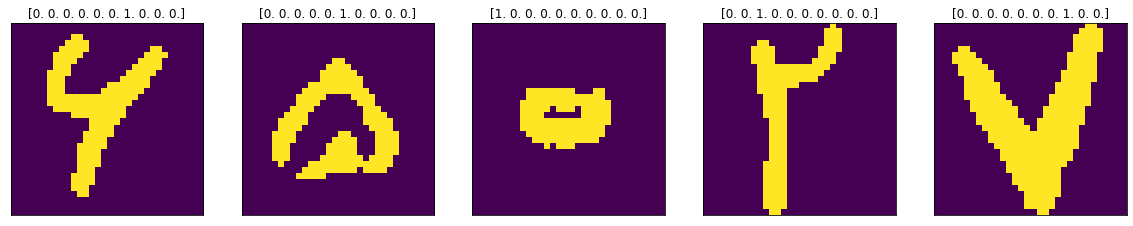

In [ ]:
fig = plt.figure(figsize=(20,20))
for i in range(5):
    ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks=[])
    ax.imshow(X_train[i].reshape(32,32))
    ax.set_title(str(y_train[i]))

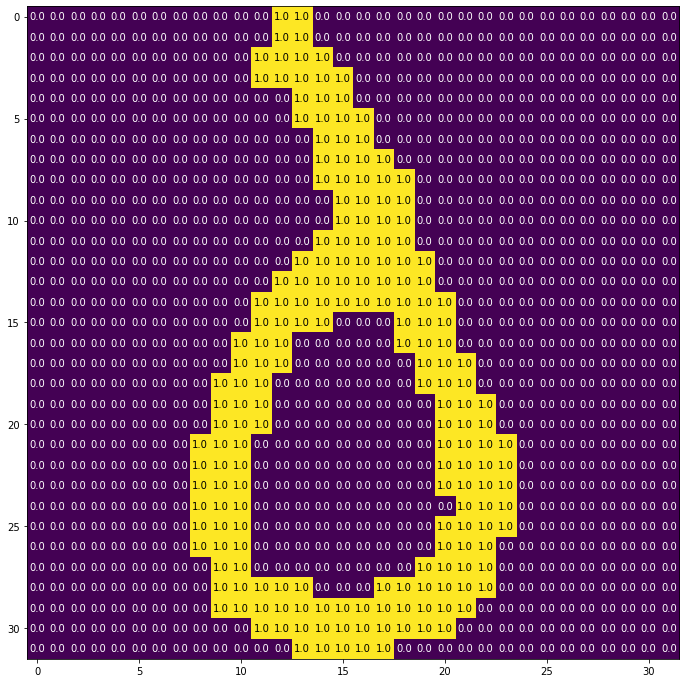

In [ ]:
# visualize one number with pixel values
def visualize_input(img, ax):
    ax.imshow(img)
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(X_train[15].reshape(32,32), ax)

## Modeling the network

In [ ]:
def network():
    # define the model
    # model = keras.Sequential()
    input_shape = (32, 32, 1)
    num_classes = 10

    model = keras.Sequential([
      layers.Conv2D(64, (3,3), padding='same', input_shape=input_shape),
      layers.BatchNormalization(momentum=0.5, epsilon=1e-5, gamma_initializer="uniform"),
      layers.LeakyReLU(alpha=0.1),
      layers.Conv2D(64,  (3,3), padding='same'),
      layers.BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"),
      layers.LeakyReLU(alpha=0.1),

      layers.MaxPooling2D(2, 2),
      layers.Dropout(0.2),
      
      layers.Conv2D(128, (3,3), padding='same'),
      layers.BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"),
      layers.LeakyReLU(alpha=0.1),
      layers.Conv2D(128, (3,3), padding='same'),
      layers.BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"),
      layers.LeakyReLU(alpha=0.1),
      
      layers.MaxPooling2D(2,2),
      layers.Dropout(0.2),    
      
      layers.Conv2D(256, (3,3), padding='same'),
      layers.BatchNormalization(momentum=0.2, epsilon=1e-5, gamma_initializer="uniform"),
      layers.LeakyReLU(alpha=0.1),
      layers.Conv2D(256, (3,3), padding='same'),
      layers.BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer="uniform"),
      layers.LeakyReLU(alpha=0.1),

      layers.MaxPooling2D(2,2),
      layers.Dropout(0.2),
      
      layers.Flatten(),
      layers.Dense(256),
      layers.LeakyReLU(alpha=0.1),
  
      layers.BatchNormalization(),
      layers.Dense(num_classes, activation='softmax')
    ])

    # summarize the model
    # model.summary()
    # keras.utils.plot_model(model, to_file='model.png')
    return model 

In [ ]:
#Training the model
batch_size = 512
num_classes = 10
epochs = 10
model = network()

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
 29/118 [======>.......................] - ETA: 22s - loss: 0.2448 - accuracy: 0.9233

KeyboardInterrupt: ignored

## Convert the model to coreml


In [ ]:
# Install tfcoreml
!pip install --upgrade tfcoreml
!pip install --upgrade coremltools

# https://github.com/tf-coreml/tf-coreml/issues/281

Requirement already up-to-date: tfcoreml in /usr/local/lib/python3.6/dist-packages (1.1)
Requirement already up-to-date: coremltools in /usr/local/lib/python3.6/dist-packages (3.3)


In [ ]:
import tfcoreml

# save the tf.keras model as .h5 model file
model_file = 'keras_hoda_model.h5'
model.save(model_file)

In [ ]:
# get input, output node names for the TF graph from the Keras model
input_name = model.inputs[0].name.split(':')[0]
keras_output_node_name = model.outputs[0].name.split(':')[0]
graph_output_node_name = keras_output_node_name.split('/')[-1]

# convert this model to Core ML format
keras_model = tfcoreml.convert(tf_model_path=model_file,
                               input_name_shape_dict={input_name: [1, 32, 32, 1]},
                               image_input_names=[input_name],
                               output_feature_names=[graph_output_node_name],
                               minimum_ios_deployment_target='13',
                               class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
                              )
                         
keras_model.save('KerasModel.mlmodel')


0 assert nodes deleted
52 nodes deleted
18 nodes deleted
0 nodes deleted
[Op Fusion] fuse_bias_add() deleted 16 nodes.
2 identity nodes deleted
8 disconnected nodes deleted
[Op Fusion] Fused 36 nodes into BatchNorms.
[SSAConverter] Converting function main ...
[SSAConverter] [1/34] Converting op type: 'Placeholder', name: 'conv2d_input', output_shape: (1, 32, 32, 1).
[SSAConverter] [2/34] Converting op type: 'Const', name: 'sequential/flatten/Const', output_shape: (2,).
[SSAConverter] [3/34] Converting op type: 'Const', name: 'sequential/batch_normalization_6/batchnorm/mul', output_shape: (256,).
[SSAConverter] [4/34] Converting op type: 'Const', name: 'sequential/batch_normalization_6/batchnorm/sub', output_shape: (256,).
[SSAConverter] [5/34] Converting op type: 'Transpose', name: 'conv2d_input_to_nchw', output_shape: (1, 1, 32, 32).
[SSAConverter] [6/34] Converting op type: 'Conv2D', name: 'sequential/conv2d/Conv2D', output_shape: (1, 64, 32, 32).
[SSAConverter] [7/34] Converting op

In [ ]:
# https://developer.apple.com/documentation/vision/recognizing_objects_in_live_capture